In [1]:
from pandas_datareader import data as pdr
import yfinance as yf
import ta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# Fetch Data

In [2]:
def fetch_data(name, start, end, scale=None):
    data = yf.download(name, start=start, end=end)
    
    if scale:
        scaler = MinMaxScaler()
        data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
    
    return data

    

def add_target_column (data,variable, name):
    tmp = data[variable].diff().shift(-1).values
    data.loc[:,name] = [ 1 if tmp[i] > 0 else 0 for i in range(tmp.shape[0])]

    return data

def add_ta_features(data,window_sizes=[10]):

    obv =  ta.volume.on_balance_volume(data['Close'], data['Volume'])
    data.loc[:,'OBV'] = obv

    for i in window_sizes:
    
        rsi =  ta.momentum.RSIIndicator(data['Close'], window = i, fillna = True)
        data.loc[:,'RSI_{}'.format(i)] = rsi.rsi()
        
        roc =  ta.momentum.ROCIndicator(data['Close'], window = i, fillna = True)
        data.loc[:,'ROC_{}'.format(i)] = roc.roc()
        
        sma = ta.trend.SMAIndicator(data['Close'],window = i, fillna = True)
        data.loc[:,'SMA_{}'.format(i)] = sma.sma_indicator()
    
        wma = ta.trend.WMAIndicator(data['Close'],window = i, fillna = True)
        data.loc[:,'WMA_{}'.format(i)] = wma.wma()

        kama = ta.momentum.KAMAIndicator(data['Close'],window = i, fillna = True)
        data.loc[:,'KAMA_{}'.format(i)] = kama.kama()

    return data

def add_ratio_trend_features(data, target,variable, window_sizes = [2,5,10,20,40,60]):
    
    
    for hor in window_sizes:
        
        rolling_averages = data.rolling(hor).mean()
        
        ratio_col = 'ratio_{}'.format(hor)
        data.loc[:,ratio_col] = data[variable]/rolling_averages[variable]
        
        if target in data.columns:
            
            trend_col = 'rTrend_{}'.format(hor)
            data.loc[:,trend_col] = data.shift(1).rolling(hor).sum(
                    )[target]
            
    return data
    

def add_custom_features(data):

    data['volatility'] = (data['High'] - data['Low']) / data['Low'] * 100
    data['hc_change'] = (data['Close'] - data['High']) / data['High'] * 100
    data['lc_change'] = (data['Close'] - data['Low']) / data['Low'] * 100
    data['price_change_percent'] = (data['Close'].pct_change() * 100).round(2)

    return data



# load btc, golf,oil, s&p500

In [21]:
start    ='2017-01-01'
end      ='2024-08-01'
target   = 'TargetClass' 
variable = 'Close'

import yfinance as yf
import pandas as pd
import ta
from sklearn.preprocessing import MinMaxScaler

# Fetch and process a single dataset
def process_data(name, start, end, target, variable, window_sizes=[10]):
    data = fetch_data(name, start, end, scale=False)
    data = data.bfill()
    #data = add_ta_features(data, window_sizes=window_sizes)
    #data = add_ratio_trend_features(data, target, variable)
    #data = data.dropna().copy(deep=True)
    data = add_custom_features(data)
    #data = data.bfill()
    return data

# Bitcoin data
data_btc = process_data('BTC-USD', start, end, target, variable)
data_btc = add_target_column(data_btc,variable, target)  # Added after processing
data_btc = data_btc.rename(columns=lambda x: x + '_btc')

# Gold data
data_gold = process_data('GC=F', start, end, target, variable)
data_gold = data_gold.rename(columns=lambda x: x + '_gold')

# Oil data
data_oil = process_data('CL=F', start, end, target, variable)
data_oil = data_oil.rename(columns=lambda x: x + '_oil')

#SP500 Data

data_sp500 = process_data('^GSPC', start, end,target,variable)
data_sp500 = data_sp500.rename(columns=lambda x: x + '_sp500')

# Merging datasets
data = pd.merge(data_btc.reset_index(), data_gold.reset_index(), on='Date', how='left')
data = pd.merge(data, data_oil.reset_index(), on='Date', how='left')
data = pd.merge(data, data_sp500.reset_index(), on='Date', how='left')

# Drop columns or perform further operations as needed
# Example: data = data.dropna()


data.to_csv('data/btc_gold_oil_sp500.csv')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# Investigate nan, fill nan's

<Axes: >

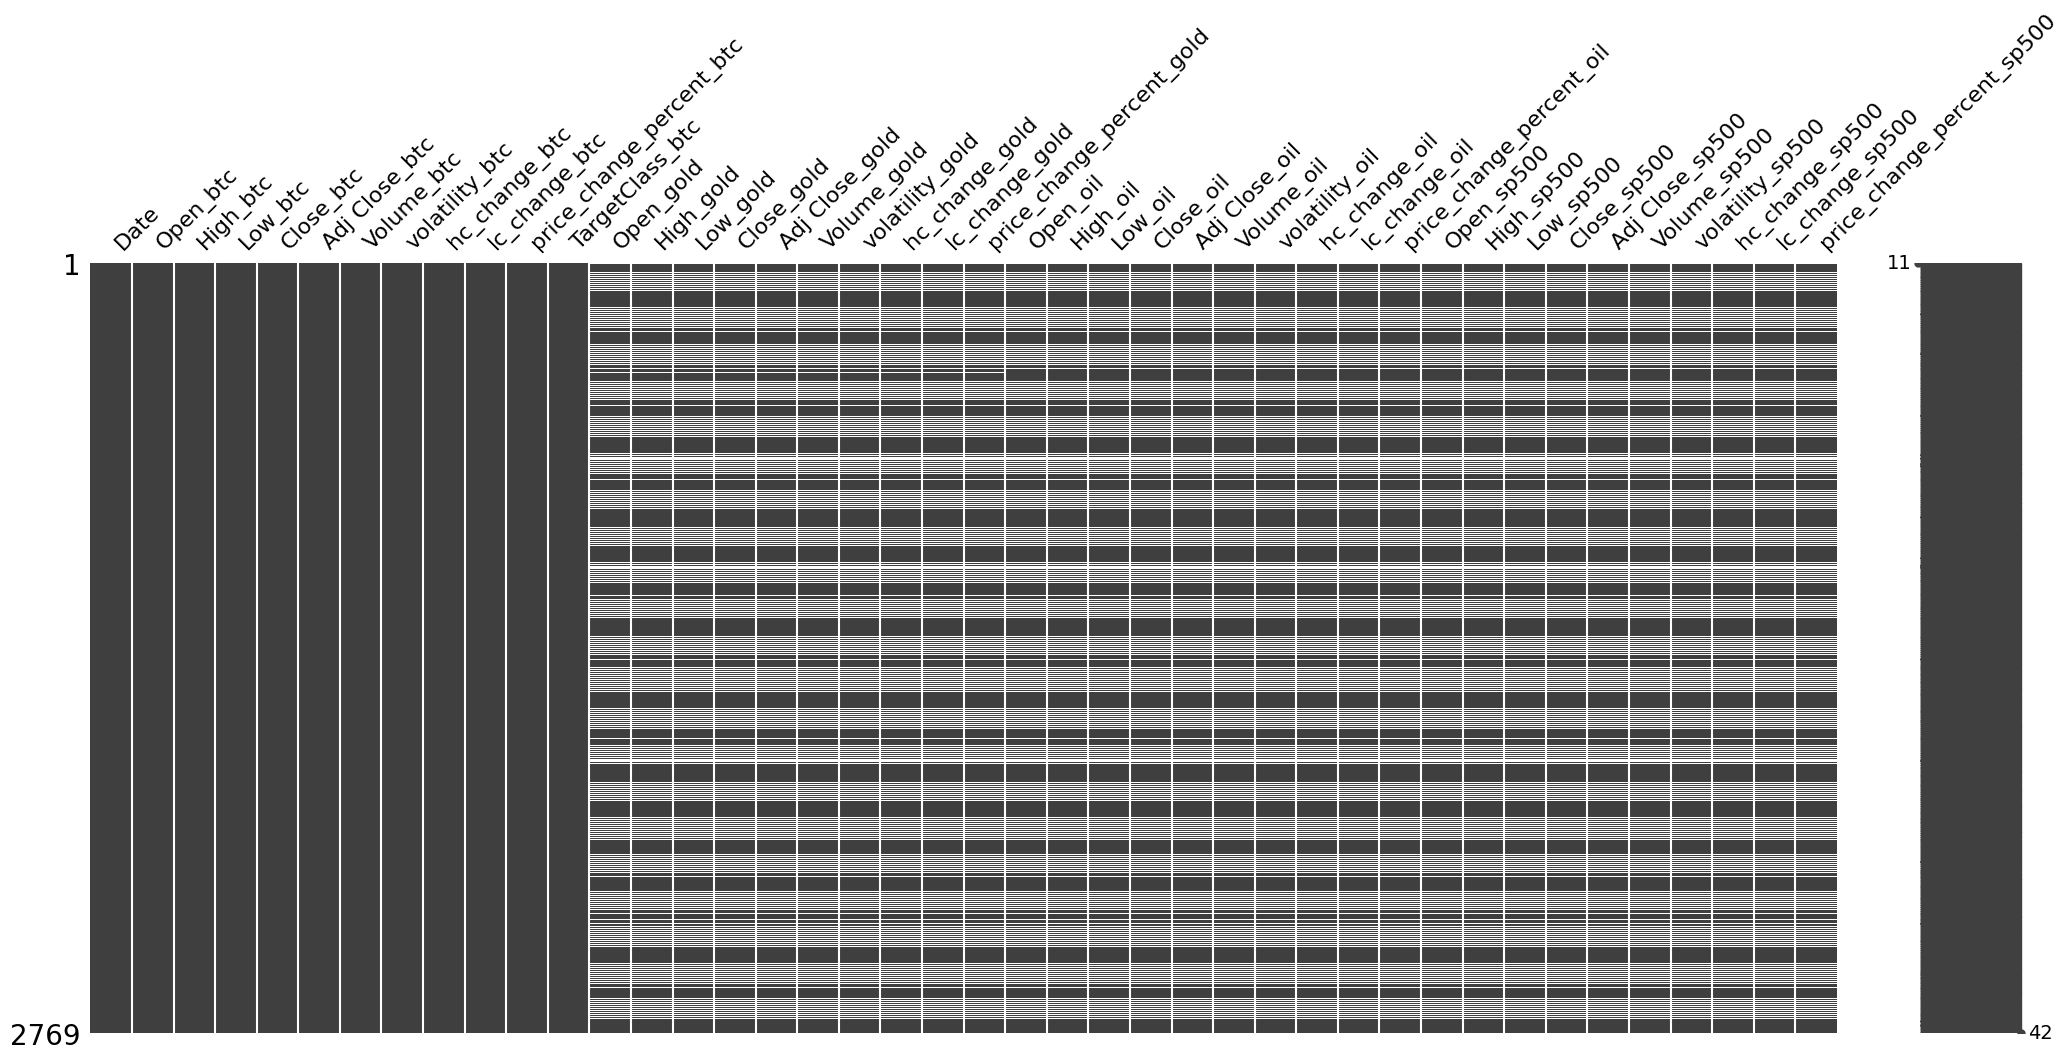

In [22]:
import missingno as msno 
msno.matrix(data)

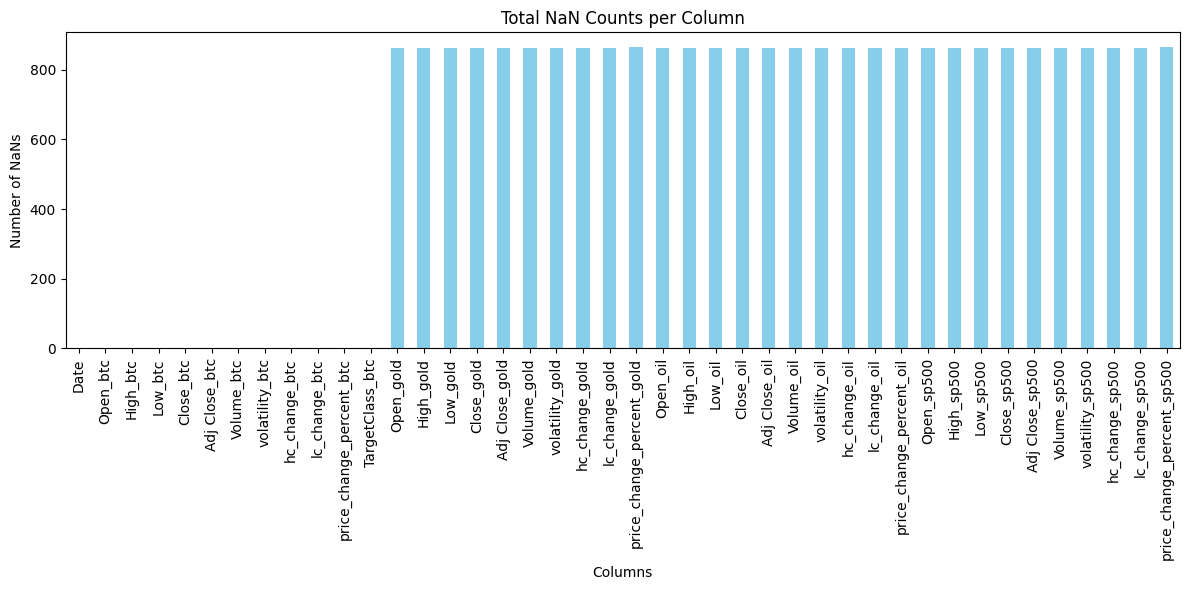

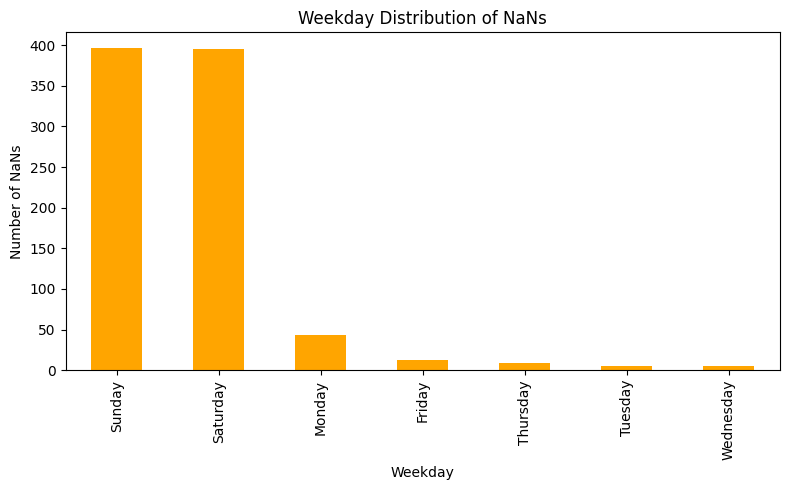

In [23]:
# Investigate the NaNs
nan_counts = data.isnull().sum()

# Check which weekdays the NaNs occur
data['Date'] = pd.to_datetime(data['Date'])
data['Weekday'] = data['Date'].dt.day_name()
nan_weekday_counts = data[data.isnull().any(axis=1)]['Weekday'].value_counts()

# Visualize the NaN counts and the weekdays
import matplotlib.pyplot as plt

# Plot the total NaN counts for each column
plt.figure(figsize=(12, 6))
nan_counts.plot(kind='bar', color='skyblue')
plt.title('Total NaN Counts per Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaNs')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot the weekday distribution of NaNs
plt.figure(figsize=(8, 5))
nan_weekday_counts.plot(kind='bar', color='orange')
plt.title('Weekday Distribution of NaNs')
plt.xlabel('Weekday')
plt.ylabel('Number of NaNs')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [25]:
data = data.bfill()

<Axes: >

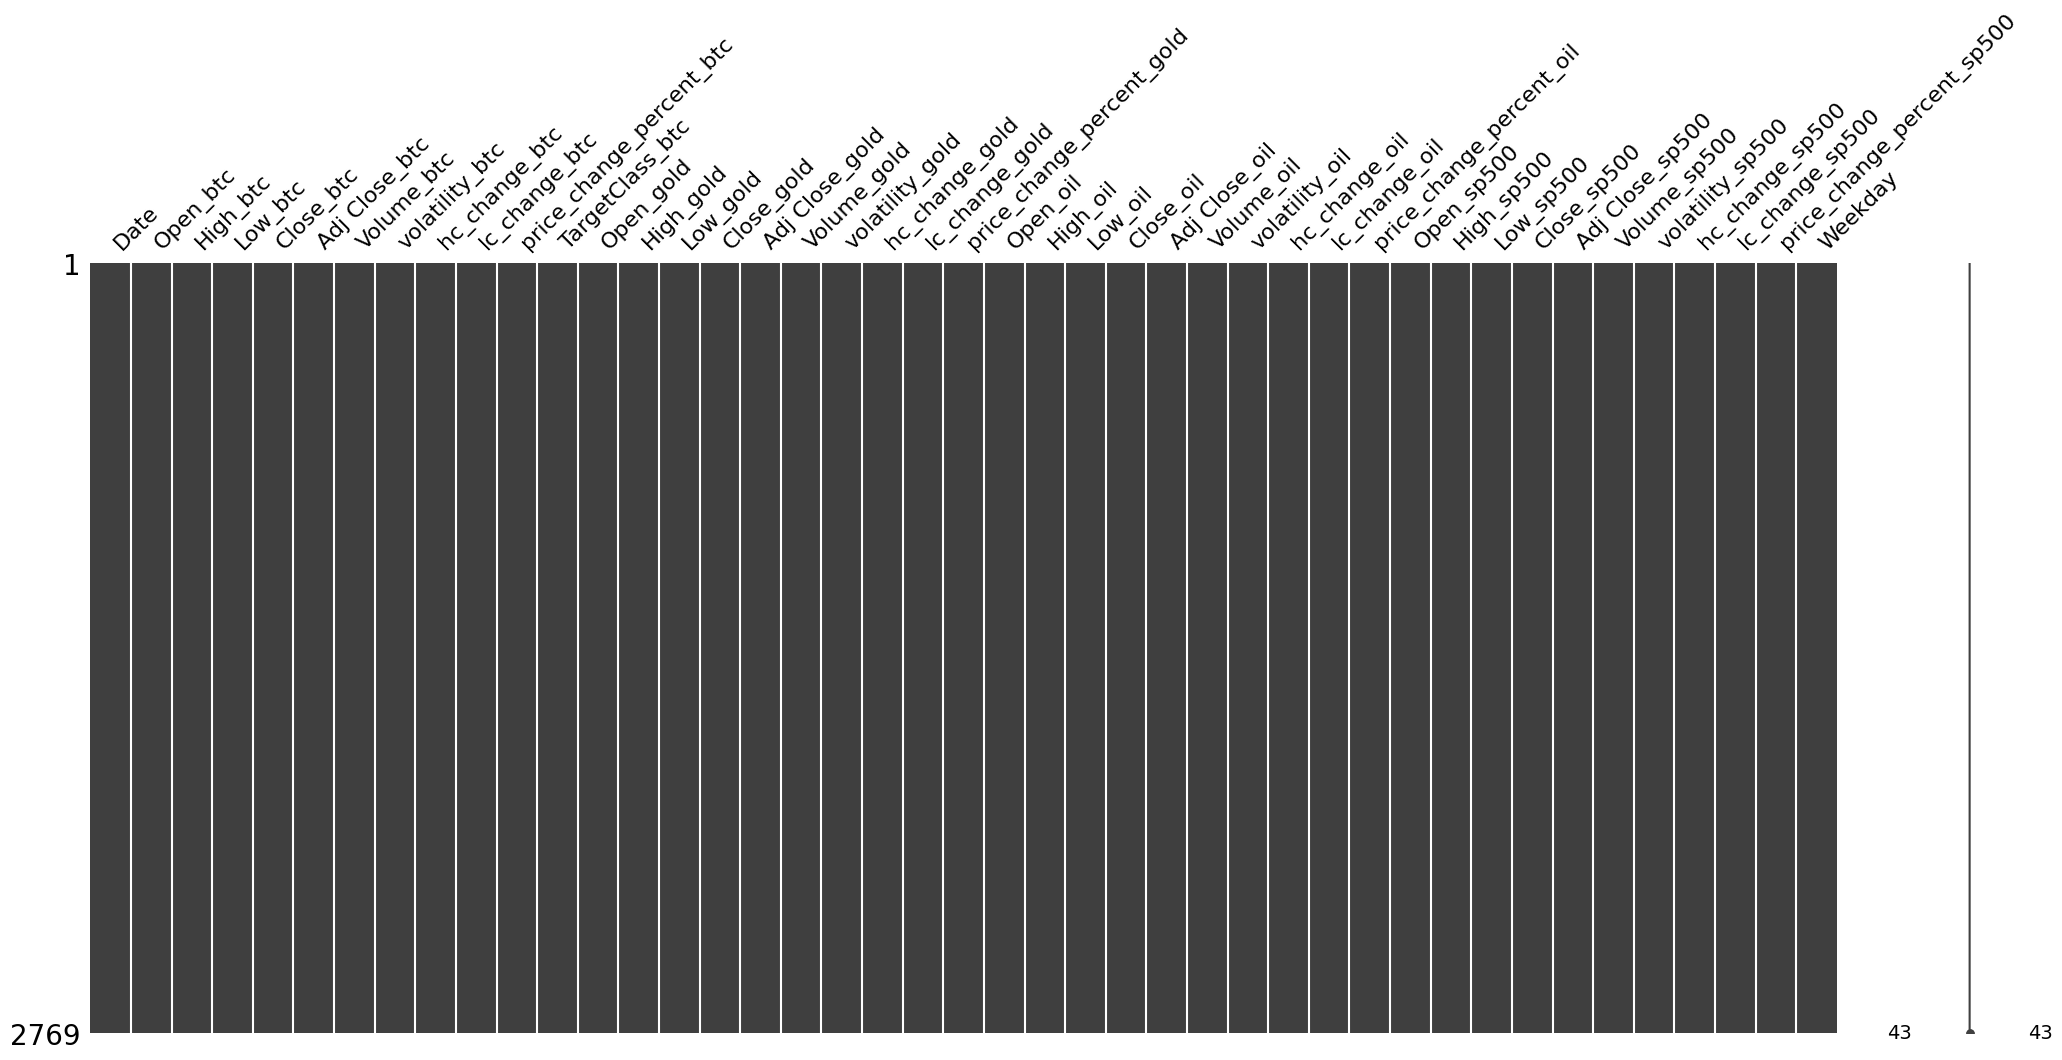

In [26]:
msno.matrix(data)

In [35]:
data.to_csv('data/btc_gold_oil_sp500_clean.csv')